# model 1 

 sara 


#  -------------------------------------------------------------------------------------------

# imports

In [1]:
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import numpy as np
from keras_tqdm import TQDMNotebookCallback
import nltk
import xml.etree.ElementTree as ET
import pandas as pd
import os
import string
from nltk.tokenize import TreebankWordTokenizer
from numpy.random import random_sample
import re
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from keras.layers import Embedding, Flatten,LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation,  Input, merge,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Convolution1D
from keras import regularizers
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from keras.layers import Concatenate, concatenate
from keras import backend as K
from keras.layers import multiply
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.regularizers import l2 
random_seed=1337

Using TensorFlow backend.


###  Define Callback functions to generate Measures

In [2]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Experiments to reproduce the results of Table 9 

### Load pre procssed Data

In [3]:
with open('../data/pickles/train_and_test_data_sentences_snp_2class.pickle', 'rb') as handle:
#with open('../../SNP-Disease/train_and_test_data_sentences_snp_2classWiki.pickle', 'rb') as handle:

    W_train = pickle.load(handle)
    d1_train = pickle.load(handle)
    d2_train = pickle.load(handle)
    Y_train = pickle.load(handle)
    Tr_word_list = pickle.load(handle)
    
    W_test = pickle.load(handle)
    d1_test = pickle.load(handle)
    d2_test = pickle.load(handle)
    Y_test = pickle.load(handle)
    Te_word_list = pickle.load(handle)
    
    
    word_vectors = pickle.load(handle)
    word_dict = pickle.load(handle)
    d1_dict = pickle.load(handle)
    d2_dict = pickle.load(handle)
    label_dict = pickle.load(handle)
    MAX_SEQUENCE_LENGTH = pickle.load(handle)
    
    
    

### Prepare Word Embedding Layer

In [4]:
EMBEDDING_DIM=word_vectors.shape[1]
embedding_matrix=word_vectors

def create_embedding_layer(l2_reg=0.1,use_pretrained=True,is_trainable=False):
    
    if use_pretrained:        
        return Embedding(len(word_dict) ,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=is_trainable,embeddings_regularizer=regularizers.l2(l2_reg))
    else:    
        return Embedding(len(word_dict) ,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)
            

### Create the Model

In [5]:
def build_model():    
    
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer=create_embedding_layer(use_pretrained=True,is_trainable=False)
    embedded_sequences = embedding_layer(sequence_input)

    x = Conv1D(256, 7, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.5)(x)
    
 
    
    conv_sequence=GlobalMaxPooling1D()(x)    #x = Flatten()(x)

    
    forward = LSTM(100,recurrent_dropout=0.05)(embedded_sequences)
    backward = LSTM(100, go_backwards=True,recurrent_dropout=0.05)(embedded_sequences)
    lstm_sequence = concatenate([forward,backward])
    merge = concatenate([conv_sequence,lstm_sequence])
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05))(merge)
    x = Dropout(0.5)(x)
    preds = Dense(2, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc',f1])
    #model.summary()
    return model

In [6]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 91)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 91, 200)      555000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 85, 256)      358656      embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 28, 256)      0           conv1d_1[0][0]                   
____________________________________________________________________________________________

### Run the Evaluation on the test dataset 

In [7]:
param='macro'
epochs =50
batch_size = 32
history=model.fit(W_train, Y_train,epochs=epochs,validation_data=(W_test,Y_test), batch_size=batch_size,verbose=1,callbacks=[TQDMNotebookCallback()])        
predicted = np.argmax(model.predict(W_test), axis=1)
y_test_to_label = np.argmax(Y_test, axis=1)
prec, reca, fscore, sup = precision_recall_fscore_support(y_test_to_label, predicted, average=param)
print("Precision:{:.2f}% Recall:{:.2f}% Fscore:{:.2f}% ".format(prec*100, reca*100, fscore*100))        




Train on 935 samples, validate on 365 samples


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50


Epoch 0:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 165s 176ms/step - loss: 5020.2231 - acc: 0.6898 - f1: 0.6830 - val_loss: 5016.5579 - val_acc: 0.6712 - val_f1: 0.6799
Epoch 2/50


Epoch 1:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 5s 5ms/step - loss: 5014.7614 - acc: 0.6995 - f1: 0.6999 - val_loss: 5013.1050 - val_acc: 0.6712 - val_f1: 0.6799
Epoch 3/50


Epoch 2:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 5s 5ms/step - loss: 5012.2686 - acc: 0.7615 - f1: 0.7603 - val_loss: 5011.5587 - val_acc: 0.7288 - val_f1: 0.7232
Epoch 4/50


Epoch 3:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5011.2315 - acc: 0.7540 - f1: 0.7567 - val_loss: 5010.8545 - val_acc: 0.7644 - val_f1: 0.7760
Epoch 5/50


Epoch 4:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5010.6220 - acc: 0.8086 - f1: 0.8098 - val_loss: 5010.4950 - val_acc: 0.7890 - val_f1: 0.7766
Epoch 6/50


Epoch 5:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5010.3244 - acc: 0.8396 - f1: 0.8363 - val_loss: 5010.1915 - val_acc: 0.7918 - val_f1: 0.8021
Epoch 7/50


Epoch 6:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5010.0491 - acc: 0.8727 - f1: 0.8723 - val_loss: 5010.0166 - val_acc: 0.8301 - val_f1: 0.8271
Epoch 8/50


Epoch 7:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.9400 - acc: 0.8588 - f1: 0.8625 - val_loss: 5009.8665 - val_acc: 0.8630 - val_f1: 0.8698
Epoch 9/50


Epoch 8:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.7775 - acc: 0.9016 - f1: 0.9042 - val_loss: 5009.9458 - val_acc: 0.7671 - val_f1: 0.7786
Epoch 10/50


Epoch 9:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.7097 - acc: 0.9027 - f1: 0.9052 - val_loss: 5009.6715 - val_acc: 0.8795 - val_f1: 0.8816
Epoch 11/50


Epoch 10:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.6320 - acc: 0.8952 - f1: 0.8942 - val_loss: 5009.6908 - val_acc: 0.8411 - val_f1: 0.8490
Epoch 12/50


Epoch 11:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.6914 - acc: 0.8727 - f1: 0.8760 - val_loss: 5009.7268 - val_acc: 0.8438 - val_f1: 0.8516
Epoch 13/50


Epoch 12:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.5597 - acc: 0.9016 - f1: 0.9042 - val_loss: 5009.6068 - val_acc: 0.8575 - val_f1: 0.8646
Epoch 14/50


Epoch 13:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.5841 - acc: 0.8866 - f1: 0.8859 - val_loss: 5009.6638 - val_acc: 0.8575 - val_f1: 0.8646
Epoch 15/50


Epoch 14:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 5s 5ms/step - loss: 5009.5449 - acc: 0.9005 - f1: 0.9031 - val_loss: 5009.5289 - val_acc: 0.8767 - val_f1: 0.8828
Epoch 16/50


Epoch 15:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.5286 - acc: 0.8984 - f1: 0.9010 - val_loss: 5009.5780 - val_acc: 0.8548 - val_f1: 0.8620
Epoch 17/50


Epoch 16:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.4252 - acc: 0.9187 - f1: 0.9171 - val_loss: 5009.4565 - val_acc: 0.8932 - val_f1: 0.8984
Epoch 18/50


Epoch 17:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 5s 5ms/step - loss: 5009.4645 - acc: 0.8888 - f1: 0.8842 - val_loss: 5009.7873 - val_acc: 0.7918 - val_f1: 0.8021
Epoch 19/50


Epoch 18:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.5700 - acc: 0.9016 - f1: 0.8967 - val_loss: 5009.5243 - val_acc: 0.8767 - val_f1: 0.8828
Epoch 20/50


Epoch 19:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.4246 - acc: 0.9176 - f1: 0.9198 - val_loss: 5009.5070 - val_acc: 0.8411 - val_f1: 0.8490
Epoch 21/50


Epoch 20:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3819 - acc: 0.9241 - f1: 0.9260 - val_loss: 5009.5612 - val_acc: 0.8164 - val_f1: 0.8255
Epoch 22/50


Epoch 21:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3627 - acc: 0.9380 - f1: 0.9396 - val_loss: 5009.4465 - val_acc: 0.8740 - val_f1: 0.8802
Epoch 23/50


Epoch 22:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3200 - acc: 0.9433 - f1: 0.9448 - val_loss: 5009.5167 - val_acc: 0.8575 - val_f1: 0.8646
Epoch 24/50


Epoch 23:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3045 - acc: 0.9487 - f1: 0.9500 - val_loss: 5009.4713 - val_acc: 0.8630 - val_f1: 0.8698
Epoch 25/50


Epoch 24:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3107 - acc: 0.9455 - f1: 0.9432 - val_loss: 5009.4459 - val_acc: 0.8712 - val_f1: 0.8776
Epoch 26/50


Epoch 25:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3070 - acc: 0.9401 - f1: 0.9379 - val_loss: 5009.4388 - val_acc: 0.8822 - val_f1: 0.8880
Epoch 27/50


Epoch 26:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3022 - acc: 0.9444 - f1: 0.9458 - val_loss: 5009.6281 - val_acc: 0.8274 - val_f1: 0.8359
Epoch 28/50


Epoch 27:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2907 - acc: 0.9476 - f1: 0.9490 - val_loss: 5009.4372 - val_acc: 0.8548 - val_f1: 0.8620
Epoch 29/50


Epoch 28:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2719 - acc: 0.9476 - f1: 0.9452 - val_loss: 5009.6482 - val_acc: 0.8329 - val_f1: 0.8411
Epoch 30/50


Epoch 29:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2766 - acc: 0.9476 - f1: 0.9452 - val_loss: 5009.4913 - val_acc: 0.8630 - val_f1: 0.8698
Epoch 31/50


Epoch 30:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2933 - acc: 0.9465 - f1: 0.9479 - val_loss: 5009.5795 - val_acc: 0.8384 - val_f1: 0.8464
Epoch 32/50


Epoch 31:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3278 - acc: 0.9273 - f1: 0.9254 - val_loss: 5009.4641 - val_acc: 0.8658 - val_f1: 0.8724
Epoch 33/50


Epoch 32:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3395 - acc: 0.9283 - f1: 0.9265 - val_loss: 5009.4196 - val_acc: 0.8986 - val_f1: 0.9036
Epoch 34/50


Epoch 33:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3730 - acc: 0.9230 - f1: 0.9250 - val_loss: 5009.7362 - val_acc: 0.8164 - val_f1: 0.8255
Epoch 35/50


Epoch 34:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3470 - acc: 0.9369 - f1: 0.9385 - val_loss: 5009.4812 - val_acc: 0.8384 - val_f1: 0.8464
Epoch 36/50


Epoch 35:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3356 - acc: 0.9337 - f1: 0.9354 - val_loss: 5009.6428 - val_acc: 0.8274 - val_f1: 0.8359
Epoch 37/50


Epoch 36:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3129 - acc: 0.9401 - f1: 0.9417 - val_loss: 5009.5119 - val_acc: 0.8548 - val_f1: 0.8620
Epoch 38/50


Epoch 37:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.3029 - acc: 0.9455 - f1: 0.9432 - val_loss: 5009.6202 - val_acc: 0.8356 - val_f1: 0.8438
Epoch 39/50


Epoch 38:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2640 - acc: 0.9561 - f1: 0.9573 - val_loss: 5009.7335 - val_acc: 0.8110 - val_f1: 0.8203
Epoch 40/50


Epoch 39:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.4491 - acc: 0.9112 - f1: 0.9135 - val_loss: 5009.9331 - val_acc: 0.7890 - val_f1: 0.7995
Epoch 41/50


Epoch 40:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2912 - acc: 0.9508 - f1: 0.9484 - val_loss: 5009.4963 - val_acc: 0.8685 - val_f1: 0.8750
Epoch 42/50


Epoch 41:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2692 - acc: 0.9583 - f1: 0.9594 - val_loss: 5009.5908 - val_acc: 0.8329 - val_f1: 0.8411
Epoch 43/50


Epoch 42:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2538 - acc: 0.9540 - f1: 0.9552 - val_loss: 5009.6281 - val_acc: 0.8274 - val_f1: 0.8359
Epoch 44/50


Epoch 43:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2540 - acc: 0.9626 - f1: 0.9635 - val_loss: 5009.5647 - val_acc: 0.8521 - val_f1: 0.8594
Epoch 45/50


Epoch 44:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2403 - acc: 0.9679 - f1: 0.9650 - val_loss: 5009.5497 - val_acc: 0.8466 - val_f1: 0.8542
Epoch 46/50


Epoch 45:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2431 - acc: 0.9668 - f1: 0.9677 - val_loss: 5009.6906 - val_acc: 0.8301 - val_f1: 0.8385
Epoch 47/50


Epoch 46:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2070 - acc: 0.9797 - f1: 0.9802 - val_loss: 5009.5649 - val_acc: 0.8356 - val_f1: 0.8438
Epoch 48/50


Epoch 47:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 5s 5ms/step - loss: 5009.2694 - acc: 0.9572 - f1: 0.9583 - val_loss: 5009.6867 - val_acc: 0.8384 - val_f1: 0.8464
Epoch 49/50


Epoch 48:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 5s 5ms/step - loss: 5009.2499 - acc: 0.9679 - f1: 0.9688 - val_loss: 5009.6816 - val_acc: 0.8329 - val_f1: 0.8411
Epoch 50/50


Epoch 49:   0%|          | 0/935 [00:00<?, ?it/s]

935/935 [==============================] - 4s 5ms/step - loss: 5009.2950 - acc: 0.9294 - f1: 0.9312 - val_loss: 5009.6302 - val_acc: 0.8384 - val_f1: 0.8425
Precision:82.89% Recall:79.46% Fscore:80.76% 


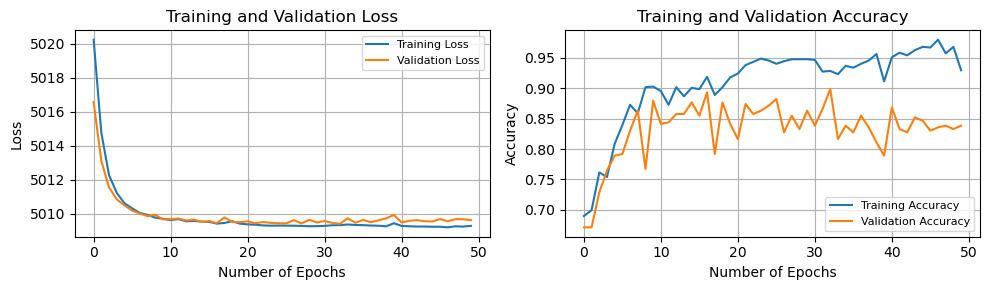

In [8]:
import matplotlib.pyplot as plt

# Training & Validation accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = len(train_loss)

xc = range(epochs)

plt.figure(figsize=(10, 3))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(xc, train_loss, label='Training Loss')
plt.plot(xc, val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Training and Validation Loss', fontsize=12)
plt.legend(fontsize=8)
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(xc, train_acc, label='Training Accuracy')
plt.plot(xc, val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Training and Validation Accuracy', fontsize=12)
plt.legend(fontsize=8, loc='lower right')  # Change position to lower right
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
# Predict on the training dataset
train_predictions = np.argmax(model.predict(W_train), axis=1)

# Calculate accuracy
train_accuracy = accuracy_score(np.argmax(Y_train, axis=1), train_predictions)

# Print accuracy
print("Accuracy on Training Data: {:.3f}".format(train_accuracy))

# Print classification report
print("Classification Report on Training Data:")
print(classification_report(np.argmax(Y_train, axis=1), train_predictions))


Accuracy on Training Data: 0.968
Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       233
           1       0.97      0.99      0.98       702

    accuracy                           0.97       935
   macro avg       0.96      0.95      0.96       935
weighted avg       0.97      0.97      0.97       935



In [10]:
print('Running predictions...')
all_predictions, all_labels = [], []
labels = np.argmax(Y_test, axis=1)
y_pred = np.argmax(model.predict(W_test), axis=1)
all_predictions.extend(y_pred.astype('int32'))
all_labels.extend(labels.astype('int32'))
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

correct_pred_count = (all_labels == all_predictions).sum()
test_acc = correct_pred_count / len(all_labels)
# show the the accuracy of testing data
print('We got %d of %d correct (or %.3f accuracy)' % (correct_pred_count, len(all_labels), test_acc))
print('Accuracy:', accuracy_score(y_true=all_labels, y_pred=all_predictions))


# Generate the classification report as a dictionary
report_dict = classification_report(y_test_to_label, predicted, output_dict=True)

# Create a new dictionary to hold the formatted values
formatted_report_dict = {}

# Iterate over the items in the report dictionary
for key, value in report_dict.items():
    if isinstance(value, dict):
        # Format the nested dictionary values
        formatted_report_dict[key] = {sub_key: f"{sub_value:.4f}" for sub_key, sub_value in value.items()}
    else:
        # Format the top-level dictionary values
        formatted_report_dict[key] = f"{value:.4f}"

# Create a string representation of the formatted dictionary
formatted_report_str = classification_report(y_test_to_label, predicted, digits=4)

# Print the formatted classification report
print(formatted_report_str)
print(" Precision:{:.2f}% Recall:{:.2f}% Fscore:{:.2f}% ".format(prec*100, reca*100, fscore*100))

Running predictions...
We got 306 of 365 correct (or 0.838 accuracy)
Accuracy: 0.8383561643835616
              precision    recall  f1-score   support

           0     0.8081    0.6667    0.7306       120
           1     0.8496    0.9224    0.8845       245

    accuracy                         0.8384       365
   macro avg     0.8289    0.7946    0.8076       365
weighted avg     0.8360    0.8384    0.8339       365

 Precision:82.89% Recall:79.46% Fscore:80.76% 


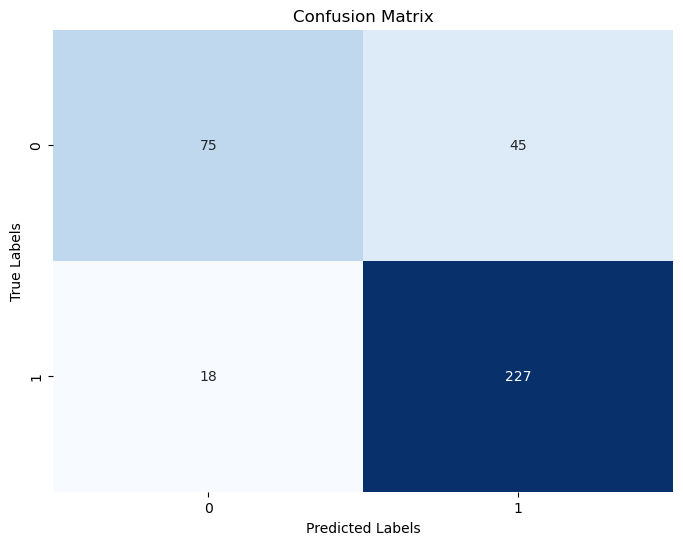

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels
predicted_labels = np.argmax(model.predict(W_test), axis=1)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()